In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [16]:
ten_stocks_close = pd.read_csv('close_df.csv')

In [17]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [18]:
close_price = ten_stocks_close['002302.XSHE'].dropna()

## Ljung Box Test on close price

In [19]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,15585.314223,0.0


## Stationarity on close price first

In [20]:
test_stationarity(close_price) # p-value is larger than 0.05. Has unit root

Results of Dickey-Fuller Test:
Test Statistic                   -2.767398
p-value                           0.063084
#Lags Used                       11.000000
Number of Observations Used    1414.000000
Critical Value (1%)              -3.434983
Critical Value (5%)              -2.863586
Critical Value (10%)             -2.567859
dtype: float64


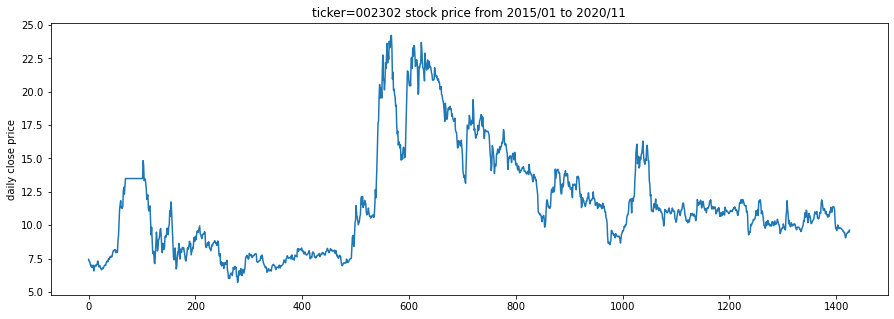

In [21]:
# visualize daily close data, lable y = column 1, ticker = 002302
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=002302 stock price from 2015/01 to 2020/11')
plt.show()

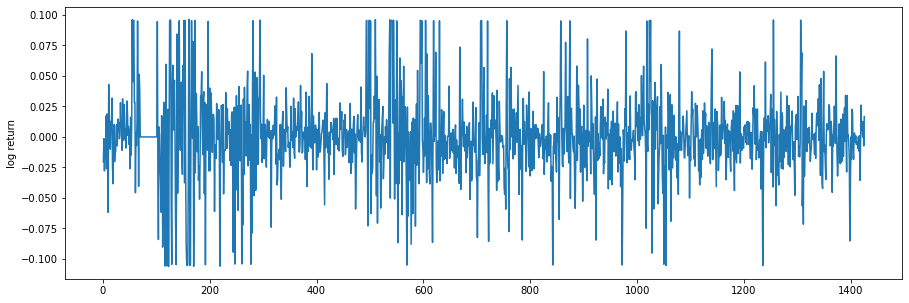

In [22]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [23]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                -1.049759e+01
p-value                        1.105205e-18
#Lags Used                     1.000000e+01
Number of Observations Used    1.414000e+03
Critical Value (1%)           -3.434983e+00
Critical Value (5%)           -2.863586e+00
Critical Value (10%)          -2.567859e+00
dtype: float64


## ACF & PACF

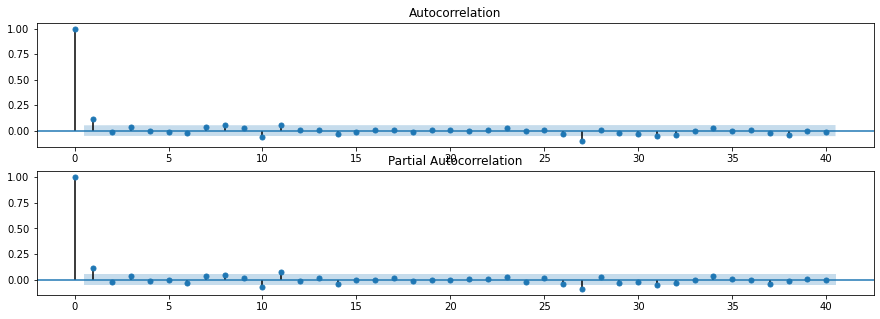

In [24]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

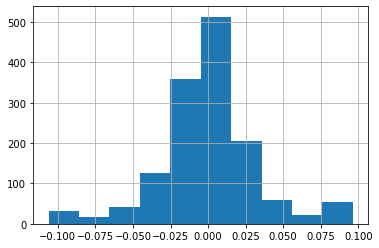

In [25]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [26]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
        p = param[0]
        q = param[1]
        model = ARIMA(log_rtn, order=(p,0,q))

        model_fit = model.fit(disp=0)

        ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q], return_df=True).values[0][1]
        aic = model_fit.aic
        return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}
        

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    try:
        results = results.append(train_ARMA(pq), ignore_index=True)
    except:
        continue

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
18,4.0,3.0,0.954627,-5653.744333
14,3.0,4.0,0.986519,-5653.089325
19,4.0,4.0,0.962049,-5651.961896
7,2.0,1.0,0.549124,-5651.805692
8,2.0,2.0,0.446607,-5649.854493
11,3.0,1.0,0.451329,-5649.840267
12,3.0,2.0,0.954396,-5648.006469
5,1.0,1.0,0.113437,-5647.944194
1,0.0,2.0,0.094957,-5647.137191
2,0.0,3.0,0.605957,-5646.972880


## GARCH

In [27]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

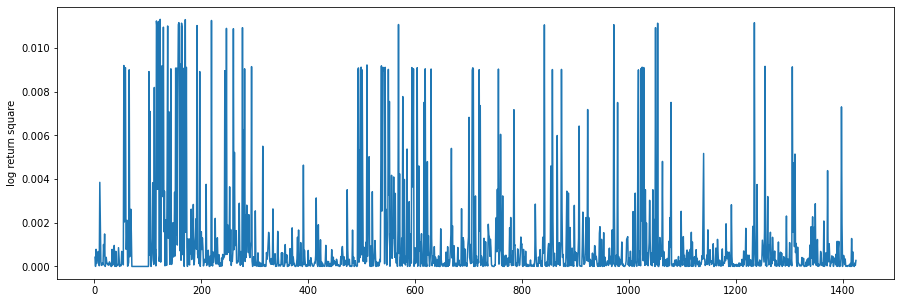

In [28]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [29]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 2.926737392923172e-150
Conclusion: Has ARCH's property in log rtn


In [30]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2960.491925915648
            Iterations: 14
            Function evaluations: 95
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2958.2137158534097
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2954.646403359905
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2960.4919315070288
            Iterations: 27
            Function evaluations: 221
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2960.596516923539
            Iterations: 18
            Function eval

,p,q,alpha,beta,ljung_p,aic


## EGARCH

In [32]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_EGARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, vol='EGARCH', mean='constant', p=p, q=q, dist='t')
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    return {'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

for pq in combinations:
    results = results.append(train_EGARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5929.298894409325
            Iterations: 11
            Function evaluations: 111
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3074.6569488515233
            Iterations: 39
            Function evaluations: 318
            Gradient evaluations: 39
Optimization terminated successfully    (Exit mode 0)

C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,



            Current function value: -3075.068122997275
            Iterations: 29
            Function evaluations: 264
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4117.720715230815
            Iterations: 41
            Function evaluations: 347
            Gradient evaluations: 37
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3075.5924244601956
            Iterations: 74
            Function evaluations: 658
            Gradient evaluations: 74
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3076.2698318038897
            Iterations: 54
            Function evaluations: 531
            Gradient evaluations: 54
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3076.665592737858
            Iterations: 62
            Function evaluations: 569
            Gradient evaluations: 

C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


,p,q,params,ljung_p,aic
6,3,1,mu -0.000115 omega -0.266238 alph...,0.241678,-6139.331185
1,1,2,mu -0.000120 omega -0.350456 alph...,0.251745,-6137.313898
4,2,2,mu -0.000116 omega -0.672948 alph...,0.257551,-6137.184849
5,2,3,mu -0.000114 omega -0.627018 alph...,0.240931,-6136.539664
2,1,3,mu -1.150109e-04 omega -3.481647e...,0.271032,-6136.136246
8,3,3,mu -1.157564e-04 omega -2.802088e...,0.241028,-6135.343419
0,1,1,mu -7.526706 omega -12.455363 al...,1.000000,11868.597789
7,3,2,mu -24.591416 omega 2.417369 al...,1.000000,14522.395882
